In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax.config import config
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.interpolate import griddata

from jaxbo.models import GP
from jaxbo.utils import normalize, compute_w_gmm
from jaxbo.test_functions import *

onp.random.seed(1234)

In [2]:
# Define test function
f, p_x, dim, lb, ub = oakley()

# Problem settings
N = 5
noise = 0.0
options = {'kernel': 'RBF',
           'criterion': 'LW-LCB', 
           'input_prior': p_x,
           'kappa': 2.0,
           'nIter': 20}
gp_model = GP(options)

# Domain bounds
bounds = {'lb': lb, 'ub': ub}

# Initial training data
X = lb + (ub-lb)*lhs(dim, N)
y = vmap(f)(X)
y = y + noise*y.std(0)*onp.random.normal(y.shape)

# Test data
if dim == 1:
    create_plots = True
    nn = 1000
    X_star = np.linspace(lb[0], ub[0], nn)[:,None]
    y_star = vmap(f)(X_star)
elif dim == 2:
    create_plots = True
    nn = 80
    xx = np.linspace(lb[0], ub[0], nn)
    yy = np.linspace(lb[1], ub[1], nn)
    XX, YY = np.meshgrid(xx, yy)
    X_star = np.concatenate([XX.flatten()[:,None], 
                             YY.flatten()[:,None]], axis = 1)
    y_star = vmap(f)(X_star)
else:
    create_plots = False
    nn = 20000
    X_star = lb + (ub-lb)*lhs(dim, nn)
    y_star = vmap(f)(X_star)

# True location of global minimum
idx_true = np.argmin(y_star)
true_x = X_star[idx_true,:]
true_y = y_star.min()
dom_bounds = tuple(map(tuple, np.vstack((lb, ub)).T))
result = minimize(f, true_x, jac=None, method='L-BFGS-B', bounds = dom_bounds)
true_x, true_y = result.x, result.fun

In [3]:
# Main Bayesian optimization loop
rng_key = random.PRNGKey(0)
for it in range(options['nIter']):
    print('-------------------------------------------------------------------')
    print('------------------------- Iteration %d/%d -------------------------' % (it+1, options['nIter']))
    print('-------------------------------------------------------------------')

    # Fetch normalized training data
    norm_batch, norm_const = normalize(X, y, bounds)

    # Train GP model
    print('Train GP...')
    rng_key = random.split(rng_key)[0]
    opt_params = gp_model.train(norm_batch,
                                rng_key,
                                num_restarts = 10)

    # Fit GMM
    if options['criterion'] == 'LW-LCB' or options['criterion'] == 'LW-US':
        print('Fit GMM...')
        rng_key = random.split(rng_key)[0]
        kwargs = {'params': opt_params,
                  'batch': norm_batch,
                  'norm_const': norm_const,
                  'bounds': bounds,
                  'rng_key': rng_key}
        gmm_vars = gp_model.fit_gmm(**kwargs, N_samples = 10000)
    else:
        gmm_vars = None

    # Compute next point via minimizing the acquisition function
    print('Computing next acquisition point...')
    kwargs = {'params': opt_params,
              'batch': norm_batch,
              'norm_const': norm_const,
              'bounds': bounds,
              'gmm_vars': gmm_vars}
    new_X = gp_model.compute_next_point_lbfgs(num_restarts=10, **kwargs)

    # Acquire data
    new_y = vmap(f)(new_X)
    new_y = new_y + noise*new_y.std(0)*onp.random.normal(new_y.shape)

    # Augment training data
    print('Updating data-set...')
    X = np.concatenate([X, new_X], axis = 0)
    y = np.concatenate([y, new_y], axis = 0)

    # Print current best
    idx_best = np.argmin(y)
    best_x = X[idx_best,:]
    best_y = y.min()
    print('True location: ({}), True value: {}'.format(true_x, true_y))
    print('Best location: ({}), Best value: {}'.format(best_x, best_y))
    print('New  location: ({}), New  value: {}'.format(new_X, new_y))

-------------------------------------------------------------------
------------------------- Iteration 1/20 -------------------------
-------------------------------------------------------------------
Train GP...
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: ([-3.66519306 -2.09439547]), True value: -4.223688146716627
Best location: ([-3.69356888 -1.14342627]), Best value: -3.3600928651033124
New  location: ([[-3.128041    0.01844083]]), New  value: [-0.07253696]
-------------------------------------------------------------------
------------------------- Iteration 2/20 -------------------------
-------------------------------------------------------------------
Train GP...
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: ([-3.66519306 -2.09439547]), True value: -4.223688146716627
Best location: ([-3.69356888 -1.14342627]), Best value: -3.3600928651033124
New  location: ([[-1.45481869 -1.06262642]]), New  value: [0

Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: ([-3.66519306 -2.09439547]), True value: -4.223688146716627
Best location: ([-3.66046056 -2.09358509]), Best value: -4.2236681781401915
New  location: ([[-3.66029491 -2.09332141]]), New  value: [-4.22366636]
-------------------------------------------------------------------
------------------------- Iteration 18/20 -------------------------
-------------------------------------------------------------------
Train GP...
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: ([-3.66519306 -2.09439547]), True value: -4.223688146716627
Best location: ([-3.66055273 -2.0934735 ]), Best value: -4.223668759681484
New  location: ([[-3.66055273 -2.0934735 ]]), New  value: [-4.22366876]
-------------------------------------------------------------------
------------------------- Iteration 19/20 -------------------------
-------------------------------------------------------------------

In [4]:
# Test accuracy
mean, std = gp_model.predict(X_star, **kwargs)
lower = mean - 2.0*std
upper = mean + 2.0*std
# Check accuracy
error = np.linalg.norm(mean-y_star,2)/np.linalg.norm(y_star,2)
print("Relative L2 error u: %e" % (error))

Relative L2 error u: 2.695244e-01


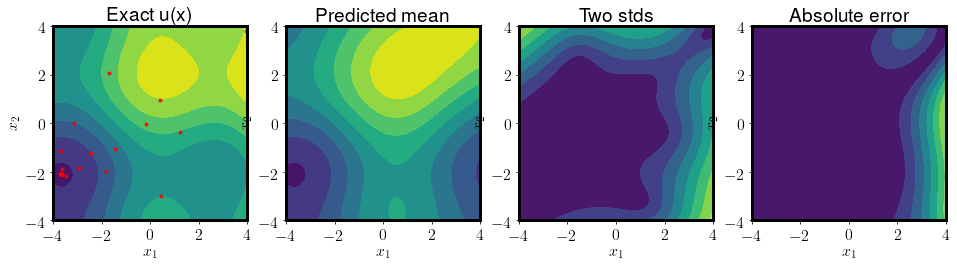

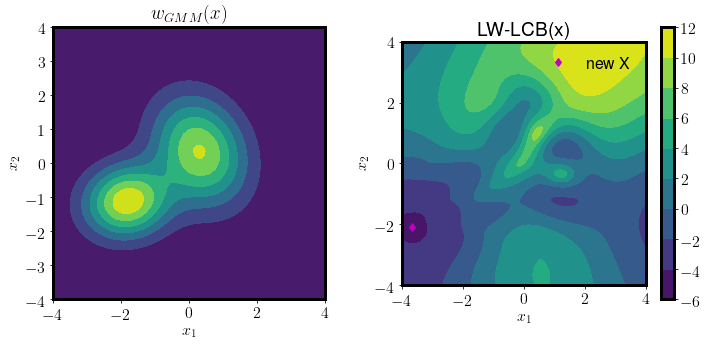

In [5]:
if create_plots:
    # Compute predictions
    if options['criterion'] == 'LW-LCB' or options['criterion'] == 'LW-US':
        w_pred = compute_w_gmm(X_star, **kwargs)
    else:
        w_pred = np.zeros(X_star.shape[0])
        
    acq_fun = lambda x: gp_model.acquisition(x, **kwargs)
    a_pred = vmap(acq_fun)(X_star)
    x_new = gp_model.compute_next_point(num_restarts=10, **kwargs)

    # Convert to NumPy
    X_star = onp.array(X_star)
    y_star = onp.array(y_star)
    mean = onp.array(mean)
    std = onp.array(std)
    w_pred = onp.array(w_pred)
    a_pred = onp.array(a_pred)
    XX = onp.array(XX)
    YY = onp.array(YY)
    Y_star = griddata(X_star, y_star, (XX, YY), method='cubic')
    Y_pred = griddata(X_star, mean, (XX, YY), method='cubic')
    Y_std  = griddata(X_star, std, (XX, YY), method='cubic')
    W_star = griddata(X_star, w_pred, (XX, YY), method='cubic')
    A_star = griddata(X_star, a_pred, (XX, YY), method='cubic')

    # Plot
    plt.rcParams.update({'font.size': 16})
    plt.rcParams['axes.linewidth']=3
    rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    rc('text', usetex=True)

    plt.figure(figsize = (16,8))
    plt.subplot(1, 4, 1)
    fig = plt.contourf(XX, YY, Y_star)
    plt.plot(X[:,0], X[:,1], 'r.', ms = 6, alpha = 0.8)
    # plt.plot(true_x[0], true_x[1], 'md', ms = 8, alpha = 1.0)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(r'Exact u(x)')
    plt.axis('square')

    plt.subplot(1, 4, 2)
    fig = plt.contourf(XX, YY, Y_pred)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(r'Predicted mean')
    plt.axis('square')

    plt.subplot(1, 4, 3)
    fig = plt.contourf(XX, YY, 2.0*Y_std)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(r'Two stds')
    plt.axis('square')

    plt.subplot(1, 4, 4)
    fig = plt.contourf(XX, YY, np.abs(Y_star-Y_pred))
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(r'Absolute error')
    plt.axis('square')
    plt.savefig('function_prediction.png', dpi = 300)

    idx_max = np.argmin(a_pred)
    plt.figure(figsize = (12,5))
    plt.subplot(1, 2, 1)
    fig = plt.contourf(XX, YY, W_star)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(r'$w_{GMM}(x)$')
    plt.axis('square')
    plt.subplot(1, 2, 2)
    fig = plt.contourf(XX, YY, A_star)
    plt.colorbar(fig)
    # plt.plot(x0[:,0], x0[:,1], 'ms')
    # plt.plot(X_star[idx_max,0], X_star[idx_max,1], 'md')
    plt.plot(x_new[:,0], x_new[:,1], 'md', label = 'new X')
    plt.legend(frameon = False)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(r'%s(x)' % (options['criterion']))
    plt.axis('square')
    plt.savefig('acquisition.png', dpi = 300)